<a href="https://colab.research.google.com/github/redrum88/tensorflow/blob/main/06_trainsfer_learning_in_tensorflow_part_3_scaling_up_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling Up (Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of transfer learning).

Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline to beat 50.76% accuracy across 101 classes.

In [ ]:
# Check to see if we're using GPU
!nvidia-smi

Sat Feb 25 12:38:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-25 12:38:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-25 12:38:12 (92.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2023-02-25 12:38:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   179MB/s    in 9.7s    

2023-02-25 12:38:44 (160 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent/train/")

There are 101 directories and 0 images in '101_food_classes_10_percent/train/'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/hummus'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/creme_brulee'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ceviche'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/greek_salad'.
There are 0 directories and

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.)
    ], name="data_augmentation")

In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so wights which need to stay frozen, stay frozen.
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layers")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layers (Dense)       (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              loss_weights=[1.0,alpha.numpy()],
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                      epochs=5,
                 #     steps_per_epoch=len(train_data_all_10_percent),
                      validation_data=test_data,
                      validation_steps=int(0.15 * len(test_data)),
                      callbacks=[checkpoint_callback])

Epoch 1/5


237/237 [==============================] - 131s 481ms/step - loss: 3.3933 - accuracy: 0.2700 - val_loss: 2.4393 - val_accuracy: 0.4738
Epoch 2/5
237/237 [==============================] - 98s 410ms/step - loss: 2.1995 - accuracy: 0.5006 - val_loss: 2.0198 - val_accuracy: 0.5204
Epoch 3/5
237/237 [==============================] - 92s 385ms/step - loss: 1.8304 - accuracy: 0.5653 - val_loss: 1.8343 - val_accuracy: 0.5477
Epoch 4/5
237/237 [==============================] - 84s 353ms/step - loss: 1.6039 - accuracy: 0.6099 - val_loss: 1.7610 - val_accuracy: 0.5498
Epoch 5/5
237/237 [==============================] - 80s 338ms/step - loss: 1.4513 - accuracy: 0.6396 - val_loss: 1.7503 - val_accuracy: 0.5485


In [ ]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 56s 71ms/step - loss: 1.5832 - accuracy: 0.5815


[1.5831878185272217, 0.5814653635025024]

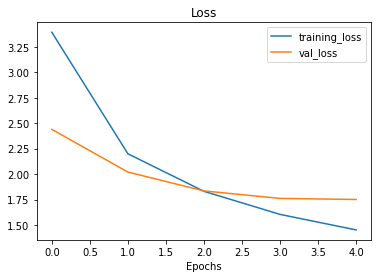

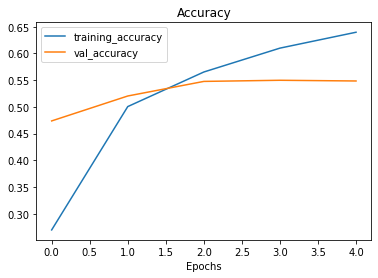

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

> 🤔 **Question:** What do these curves suggest? Hint:
ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine-tuning



In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning) rate.
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layers True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv True
6 stem_bn True
7 stem_activation True
8 block1a_dwconv True
9 block1a_bn True
10 block1a_activation True
11 block1a_se_squeeze True
12 block1a_se_reshape True
13 block1a_se_reduce True
14 block1a_se_expand True
15 block1a_se_excite True
16 block1a_project_conv True
17 block1a_project_bn True
18 block2a_expand_conv True
19 block2a_expand_bn True
20 block2a_expand_activation True
21 block2a_dwconv_pad True
22 block2a_dwconv True
23 block2a_bn True
24 block2a_activation True
25 block2a_se_squeeze True
26 block2a_se_reshape True
27 block2a_se_reduce True
28 block2a_se_expand True
29 block2a_se_excite True
30 block2a_project_conv True
31 block2a_project_bn True
32 block2b_expand_conv True
33 block2b_expand_bn True
34 block2b_expand_activation True
35 block2b_dwconv True
36 block2b_bn True
37 block2b_activation True
38 block2b_se_squeeze True
39 block2b_se_reshape True
40 block2

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10


237/237 [==============================] - 174s 572ms/step - loss: 0.2567 - accuracy: 0.9234 - val_loss: 2.4216 - val_accuracy: 0.5143
Epoch 6/10
237/237 [==============================] - 135s 570ms/step - loss: 0.2090 - accuracy: 0.9344 - val_loss: 2.2377 - val_accuracy: 0.5593
Epoch 7/10
237/237 [==============================] - 130s 546ms/step - loss: 0.1491 - accuracy: 0.9579 - val_loss: 2.1711 - val_accuracy: 0.5776
Epoch 8/10
237/237 [==============================] - 130s 546ms/step - loss: 0.1246 - accuracy: 0.9620 - val_loss: 2.5021 - val_accuracy: 0.5458
Epoch 9/10
237/237 [==============================] - 127s 533ms/step - loss: 0.1052 - accuracy: 0.9688 - val_loss: 2.5142 - val_accuracy: 0.5522
Epoch 10/10
237/237 [==============================] - 125s 525ms/step - loss: 0.1094 - accuracy: 0.9658 - val_loss: 2.4673 - val_accuracy: 0.5728


In [ ]:
# Evaluate on the whole test data
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 58s 73ms/step - loss: 2.1814 - accuracy: 0.6036


[2.1814403533935547, 0.603643536567688]

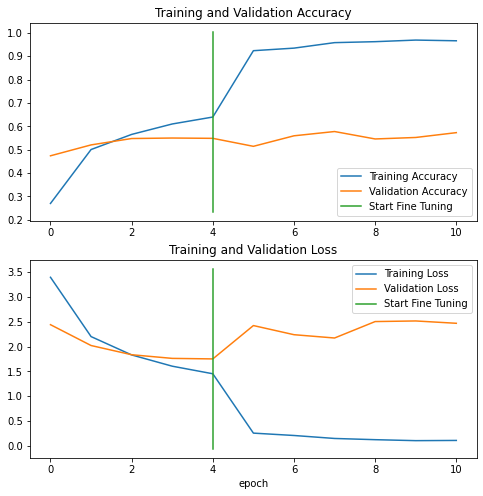

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere

In [ ]:
# Save our fine-tuned model
tf.keras.models.save_model(model=model, filepath="/content/drive/MyDrive/TENSORFLOW/101_food_classes_10_percent_saved_big_dog_model")
# model.save("/content/drive/MyDrive/TENSORFLOW/101_food_classes_10_percent_saved_big_dog_model.h5")

TypeError: ignored

In [ ]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TENSORFLOW/101_food_classes_10_percent_saved_big_dog_model")

ValueError: ignored

In [ ]:
model.save()